In [1]:
!pip install seaborn scikit-learn torch torchvision -q

### Import necessary modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

from tqdm import trange

torch.manual_seed(42)
np.random.seed(42)

### Define transforms for normalization

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Load dataset and split it into train and test

In [4]:
full_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

In [5]:
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_set, val_set = random_split(full_train, [train_size, val_size])

In [6]:
print(f"Train samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 40000
Validation samples: 10000
Test samples: 10000


In [7]:
def extract_data(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))
    data, labels = next(iter(loader))
    return data.numpy(), labels.numpy()

### Prepare data from sklearn models

In [8]:
X_train, y_train = extract_data(train_set)
X_val, y_val = extract_data(val_set)
X_test, y_test = extract_data(test_set)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Shapes after flattening:")
print(f"Train: {X_train_flat.shape}, Labels: {y_train.shape}")

Shapes after flattening:
Train: (40000, 3072), Labels: (40000,)


### Train simple KNN classifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

start_time = time.time()
knn.fit(X_train_flat, y_train)

KNeighborsClassifier(n_jobs=-1)

### Check validation accuracy

In [10]:
val_preds = knn.predict(X_val_flat)
val_acc = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.3340


### Measure performance on test set

In [11]:
test_preds = knn.predict(X_test_flat)

accuracy = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

print("kNN Test Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

kNN Test Performance:
Accuracy: 0.3322
Recall: 0.3322
F1-Score: 0.3175


### Plot confusion matrix for classes

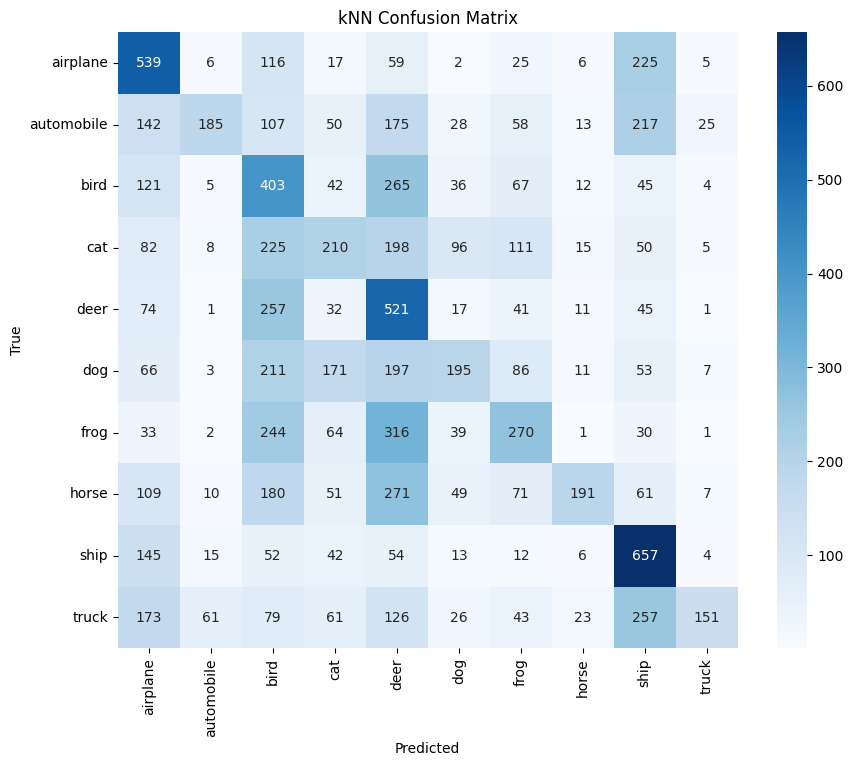

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, test_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.classes,
            yticklabels=test_set.classes)
plt.title('kNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('knn_cm.png', bbox_inches='tight')
plt.show()

### Define MLP

In [13]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
model

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Prepare data in PyTorch format

In [14]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train), torch.tensor(y_train))
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_val), torch.tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

### Define loss and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

### Train a MLP

In [16]:
epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: New best model saved with val_loss = {val_loss:.4f}")

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1: New best model saved with val_loss = 1.6026
Epoch 1/20: Train Loss: 1.7734, Acc: 0.3717 | Val Loss: 1.6026, Acc: 0.4402
Epoch 2: New best model saved with val_loss = 1.4996
Epoch 2/20: Train Loss: 1.5309, Acc: 0.4594 | Val Loss: 1.4996, Acc: 0.4720
Epoch 3: New best model saved with val_loss = 1.4373
Epoch 3/20: Train Loss: 1.4153, Acc: 0.5017 | Val Loss: 1.4373, Acc: 0.4927
Epoch 4: New best model saved with val_loss = 1.4081
Epoch 4/20: Train Loss: 1.3299, Acc: 0.5349 | Val Loss: 1.4081, Acc: 0.5138
Epoch 5: New best model saved with val_loss = 1.3908
Epoch 5/20: Train Loss: 1.2582, Acc: 0.5602 | Val Loss: 1.3908, Acc: 0.5161
Epoch 6: New best model saved with val_loss = 1.3534
Epoch 6/20: Train Loss: 1.1904, Acc: 0.5826 | Val Loss: 1.3534, Acc: 0.5326
Epoch 7/20: Train Loss: 1.1254, Acc: 0.6061 | Val Loss: 1.3651, Acc: 0.5321
Epoch 8: New best model saved with val_loss = 1.3405
Epoch 8/20: Train Loss: 1.0660, Acc: 0.6270 | Val Loss: 1.3405, Acc: 0.5353
Epoch 9/20: Train Los

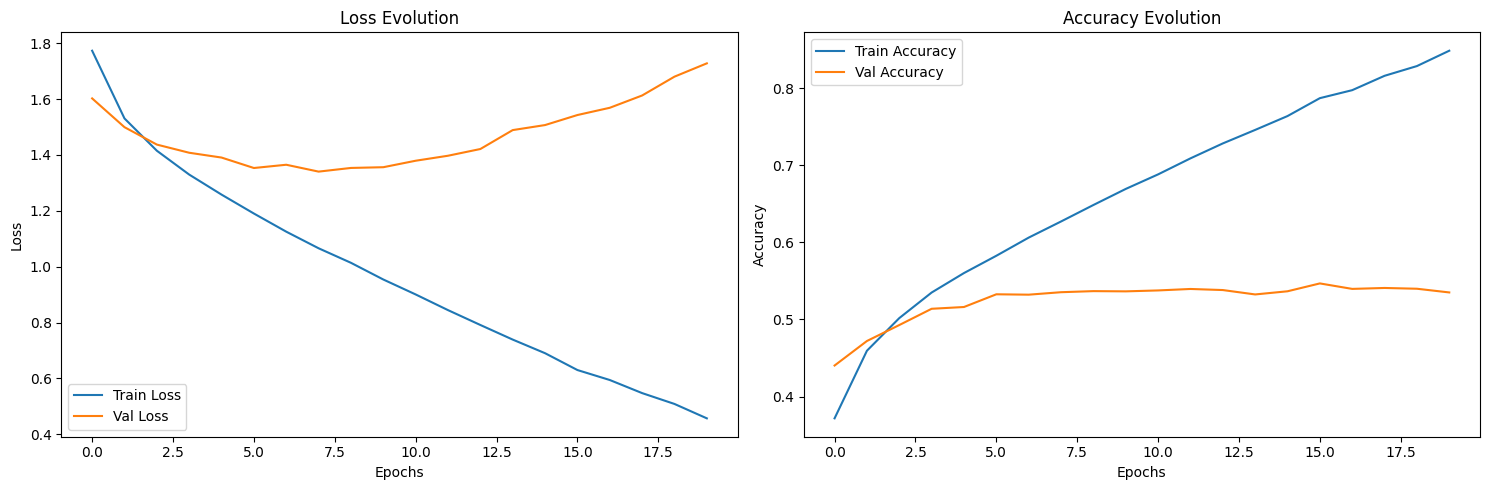

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

### load best model

In [18]:
model = MLP()
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Measure performance on test

In [19]:
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}\n")

print("Classification Report:")
print(classification_report(test_labels, test_preds))

Test Accuracy: 0.5272
Test Recall: 0.5272
Test F1-score: 0.5243

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1000
           1       0.71      0.57      0.63      1000
           2       0.44      0.42      0.43      1000
           3       0.36      0.29      0.32      1000
           4       0.51      0.35      0.41      1000
           5       0.39      0.56      0.46      1000
           6       0.53      0.65      0.59      1000
           7       0.60      0.59      0.59      1000
           8       0.61      0.69      0.65      1000
           9       0.55      0.63      0.59      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



### Plot confusion matrix for classes

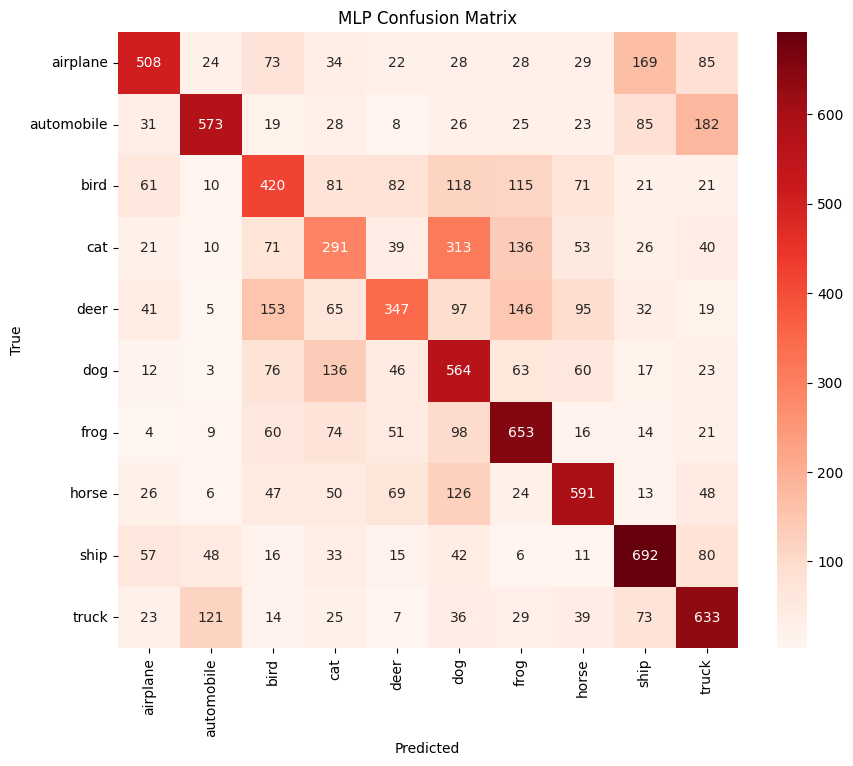

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels, test_preds),
            annot=True, fmt='d', cmap='Reds',
            xticklabels=test_set.classes,
            yticklabels=test_set.classes)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('mlp_cm.png', bbox_inches='tight')
plt.show()

### Advantages/Disadvantages:

#### kNN:

- ✅ No training required

- ❌ High memory requirements (stores all training data)

- ❌ Computationally expensive during inference

- ❌ Sensitive to feature scaling

#### MLP:

- ✅ Better performance on complex patterns

- ✅ Faster inference after training

- ❌ Requires significant training time

- ❌ Sensitive to hyperparameter choices

### Improvement Suggestions:

#### For kNN:

- Use dimensionality reduction (PCA)
- Implement approximate nearest neighbors
- Tune k-value with cross-validation

#### For MLP:

- Add convolutional layers (CNN)
- Implement data augmentation
- Use learning rate scheduling
- Add dropout/batch normalization

#### General:

- Try transfer learning (ResNet, EfficientNet)
- Use class balancing techniques
- Implement more sophisticated evaluation (ROC curves)

### Conclusion:
The MLP performed better than kNN, highlighting the advantage of neural networks in handling image data. While kNN serves as a useful baseline, its computational demands make it less suitable for tasks that require efficient processing.